# Deep Learning & Art: Neural Style Transfer

This algorithm implements Neural Style Transfer based on Deep learning techniques. It will generate a new art image by merging two images: a content image and a style image, to create a generated image.  

Ref: [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

/home/imprs/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/imprs/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/imprs/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/imprs/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

## Transfer Learning

By using a previously trained convolution network, this program will build on top of that. 

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

### Content image

In this example, the content image will be the picture of the Louvre Museum in Paris. 

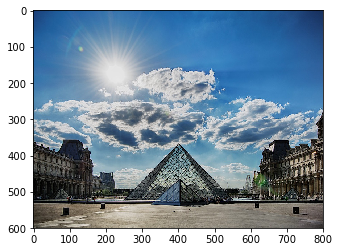

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image);

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    

    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = tf.convert_to_tensor(a_G).get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum( (a_C - a_G)**2 )

    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


### Style Image

We will use a painting from Monet as the style image 

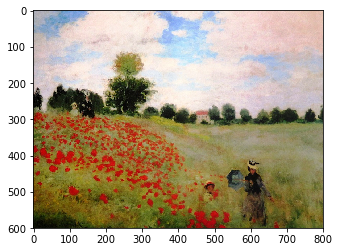

In [6]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image);

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul( A, tf.transpose(A) )
    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


The goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.



In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = tf.convert_to_tensor(a_S).get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H * n_W, n_C]) )
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C]) )

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1/(4 * n_C**2 * (n_H * n_W)**2) * tf.reduce_sum( (GS - GG)**2 )
    
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style


## Main points
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- We get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
 
    J = alpha * J_content + beta * J_style
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.



#### Start the interactive session.

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### Content image
Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [16]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

#### Style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [17]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

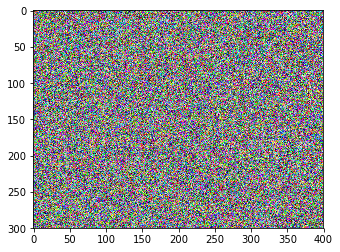

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

#### Load pre-trained VGG19 model
Let's load the VGG19 model.

In [19]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

#### Content Cost

In [20]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

### Total cost
* Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. 
* Use `alpha = 10` and `beta = 40`.

In [22]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

### Optimizer

* Use the Adam optimizer to minimize the total cost `J`.
* Use a learning rate of 2.0.  
* [Adam Optimizer documentation](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [23]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [26]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.05035e+09
content cost = 7877.68
style cost = 1.26257e+08
Iteration 20 :
total cost = 9.43272e+08
content cost = 15187.2
style cost = 2.3578e+07
Iteration 40 :
total cost = 4.84905e+08
content cost = 16785.1
style cost = 1.21184e+07
Iteration 60 :
total cost = 3.12573e+08
content cost = 17466.2
style cost = 7.80995e+06
Iteration 80 :
total cost = 2.28117e+08
content cost = 17715.3
style cost = 5.69849e+06
Iteration 100 :
total cost = 1.80691e+08
content cost = 17894.8
style cost = 4.51281e+06
Iteration 120 :
total cost = 1.50008e+08
content cost = 18026.1
style cost = 3.7457e+06
Iteration 140 :
total cost = 1.278e+08
content cost = 18187.2
style cost = 3.19046e+06
Iteration 160 :
total cost = 1.10793e+08
content cost = 18347.5
style cost = 2.76524e+06
Iteration 180 :
total cost = 9.7414e+07
content cost = 18489.9
style cost = 2.43073e+06


Content Image


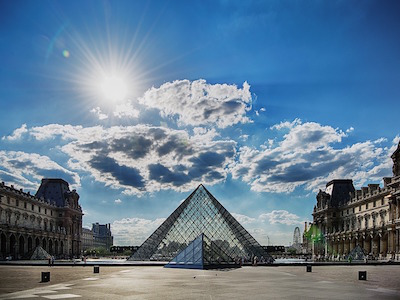

Style Image


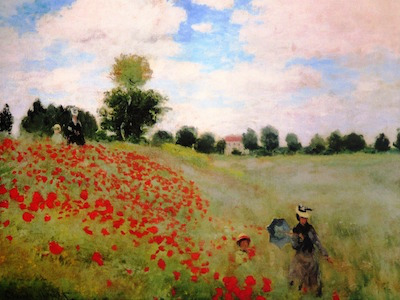

Art Generated Image


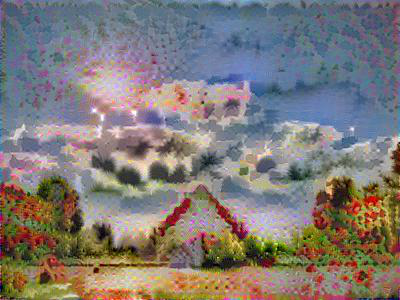

In [10]:
content_image = Image.open("images/louvre_small.jpg")
style_image = Image.open("images/monet.jpg")
generated_image = Image.open('output/generated_image.jpg')

print("Content Image")
display(content_image)

print("Style Image")
display(style_image)

print("Art Generated Image")
display(generated_image)

### Art Generated 

This algorithm combines two images, the content image and the style image to create a final art generated image shown above. 